# Homework 7: Study an integral 
by Rustam Guseyn-zade ([link canvas](https://skoltech.instructure.com/courses/3546/users/9673))

## Table of contents
* [Computing integral analytically](#Computing-integral-analytically)
* [Computing integral with trapesoidal rule](#Computing-integral-with-trapesoidal-rule)
* [Parallelize integral computation](#Parallelize-integral-computation)
* [Speedup vs Number of processors](#Speedup-vs-Number-of-processors)

In [1]:
# import needed libraries
import numpy as np
import math
import matplotlib.pyplot as plt
import time

## Computing integral analytically

From the calculus course we know, that:

$\displaystyle{\int_{-3}^1 (3x^2 - 2.5 x + 1)} = \big(x^3 - \frac{5x^2}{4} + x\big) \,\bigg|_{-3}^1 = (1 - \frac{5}{4} + 1) - (-27 - \frac{45}{4} -3) = 32 + \frac{40}{4} = 42$

## Computing integral with trapesoidal rule

In [2]:
def integral(fun, a, b, iterations=1000):
    delta = (b - a) / iterations
    approx = fun(a) / 2.
    fun_arg = a
    for _ in range(iterations-1):
        fun_arg += delta
        approx += fun(fun_arg)
    approx += fun(b) / 2.
    return approx * delta

In [3]:
integral(lambda x: 3*x**2 - 2.5*x +1, -3, 1)

42.00003199999995

## Parallelize integral computation

In [4]:
%%writefile integral.py
# Create file integral.py
import math
import matplotlib.pyplot as plt
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

fun = lambda x: 3*x**2 - 2.5*x + 1
a = -3
b = 1
iterations = 10000000

delta = (b - a) / iterations
chunk_size = (iterations)//size + 1
chunk_head = chunk_size * rank
chunk_tail = chunk_size * (rank + 1)
if chunk_tail > iterations:
    chunk_tail = iterations

fun_approx = 0
for i in range(chunk_head,chunk_tail):
    fun_approx += fun(a+delta*i)

fun_approx = comm.reduce(fun_approx, op = MPI.SUM, root = 0)

if rank == 0:
    fun_approx += fun(a) / 2. + fun(b) / 2.
    print(f"{fun_approx*delta}")

Overwriting integral.py


In [5]:
!mpirun --allow-run-as-root -np 3 python3 integral.py

42.00001419999871


## Speedup vs Number of processors

Text(0.5, 1.0, 'Integral evaluation speedup')

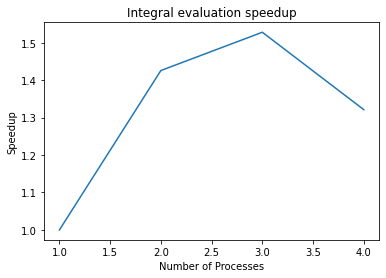

In [6]:
def measure_n_processes_time(processes_number, attempts=10):
    number_processes_time = []
    for i in range(attempts):
        start = time.time()
        !mpirun --allow-run-as-root -n {processes_number} python3 integral.py >/dev/null 2>&1
        end = time.time()
        number_processes_time.append(end - start)
        print(f'measure attempt {i+1} from {attempts} for {processes_number} processes', end='\r')
    return sum(number_processes_time) / attempts

processes_times = [measure_n_processes_time(i) for i in range(1,5)]
speedups = [processes_times[0] / processes_times[i] for i in range(len(processes_times))]
plt.plot(range(1, 5), speedups)
plt.ylabel('Speedup')
plt.xlabel('Number of Processes')
plt.title('Integral evaluation speedup')

## Integration error vs Discretization size

Text(0.5, 1.0, 'Errors changes based on discretization size')

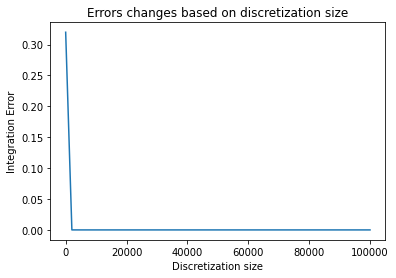

In [7]:
sizes = np.linspace(10, 100000, 50)
errors = [abs(42. - integral(lambda x: 3*x**2 - 2.5*x +1, -3, 1, int(size))) for size in sizes]
plt.plot(sizes.astype(int), errors)
plt.ylabel('Integration Error')
plt.xlabel('Discretization size')
plt.title('Errors changes based on discretization size')